## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from src.features import add_trend
from src.evaluation import Evaluation
from src.plots import plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

EVAL_PATH = '../data/evaluation.csv'

## **Leitura dos Dados**

In [2]:
# leitura dos dados
train_df = pd.read_csv("../data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("../data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [3]:
import json

with open("../data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

## **Random Forest Regression**

In [4]:
best_models = {}

params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

In [5]:
def grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=3)
    search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    search.fit(X, y)
    return search.best_params_


def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = grid_search(
        estimator=RandomForestRegressor(random_state=1001),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = RandomForestRegressor(**best_model, random_state=1001)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [6]:
# aplicando modelo para cada série
rf_fcst = train_df.groupby("unique_id")\
    .progress_apply(random_forest)\
    .reset_index(drop=True)

100%|██████████| 14/14 [24:37<00:00, 105.57s/it]


In [7]:
with open("../data/random_forest_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

In [15]:
rf_fcst[['unique_id','ds','y','y_pred']].to_csv("../data/fcst_random_forest.csv")

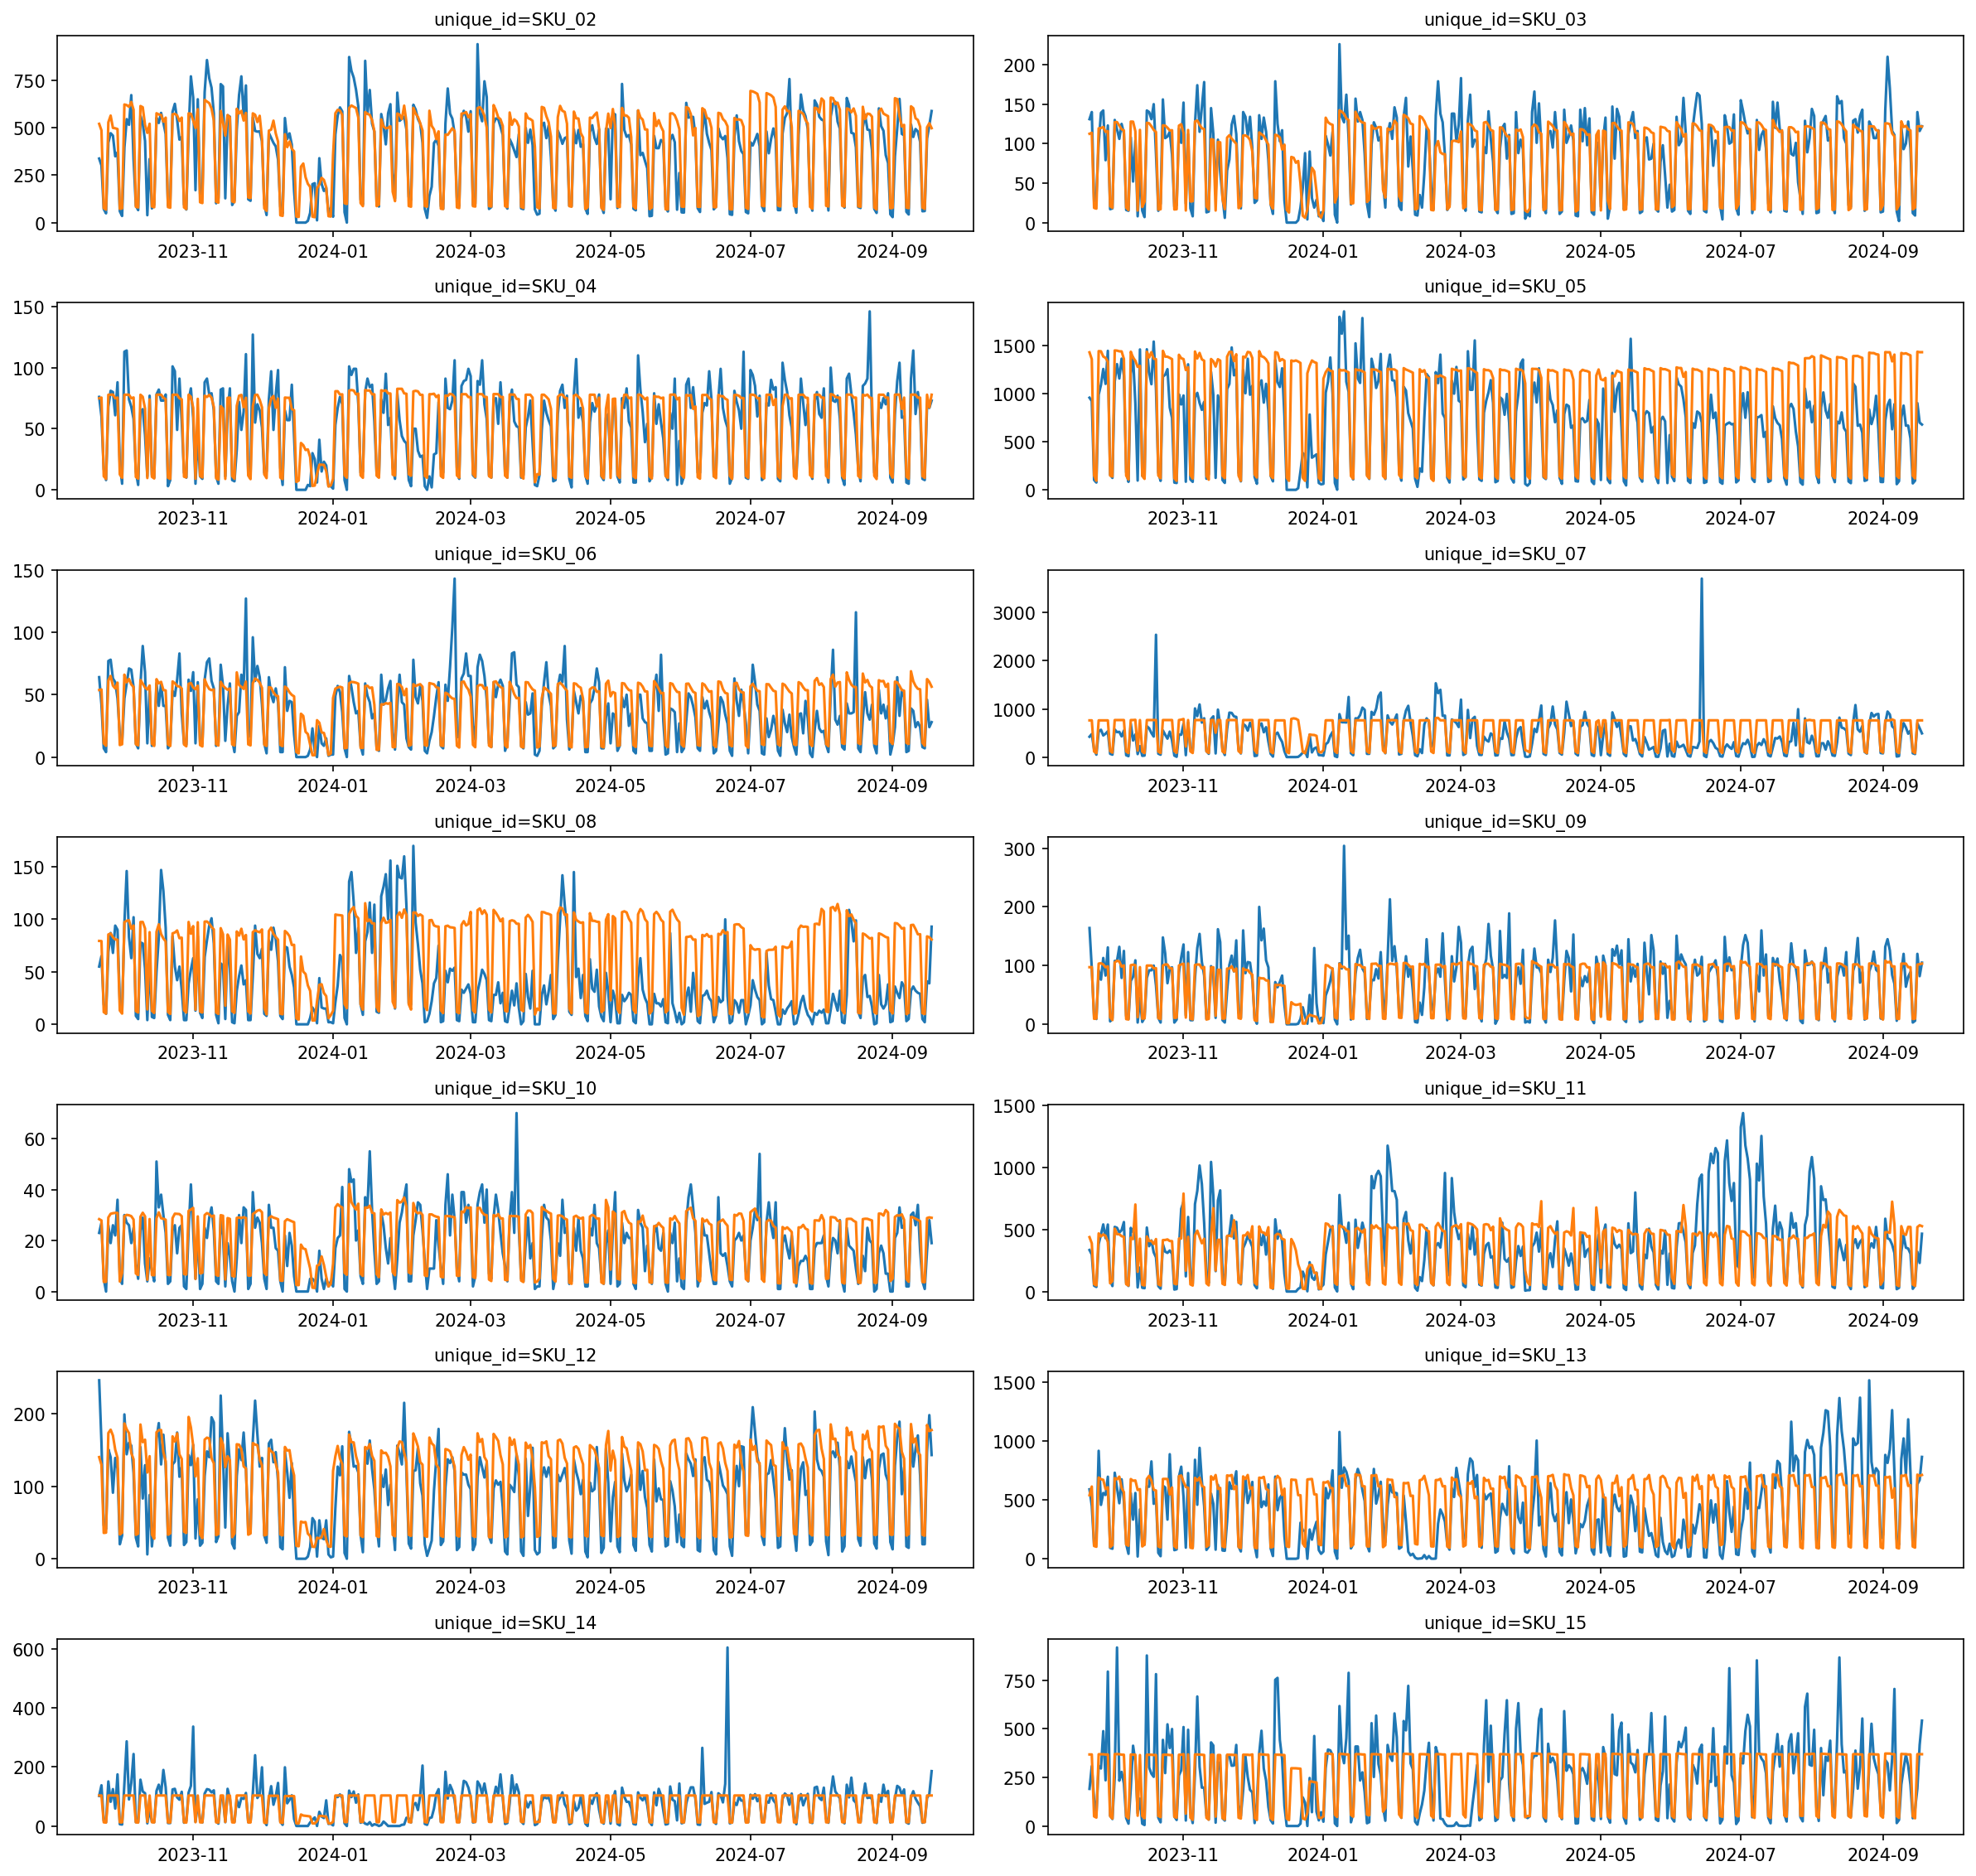

In [8]:
fig = plot_time_series(
    df=rf_fcst, 
    figsize=(16, 16),
    data_cols=['y', 'y_pred'], 
)

In [9]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_02,83.751,14172.278,119.047,0.720
SKU_03,18.397,705.461,26.561,0.749
SKU_04,12.330,309.885,17.604,0.721
SKU_05,322.838,189226.249,435.001,0.081
SKU_06,13.693,353.186,18.793,0.447
SKU_07,233.362,117484.200,342.760,0.238
SKU_08,35.993,2096.681,45.790,-0.543
SKU_09,18.574,824.625,28.716,0.687
SKU_10,6.739,78.526,8.861,0.513
SKU_11,152.269,50621.236,224.992,0.432


In [10]:
# SKU_02 
# SKU_04
# SKU_09
# SKU_12

In [12]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('r2','unique_id','model')[order]
metrics.sort_values('Random Forest', ascending=False)
metrics[metrics['Random Forest'] > metrics['XGBoost']].sort_values('Random Forest', ascending=False)

model,Naive Sazonal,SARIMA,ETS,Decision Tree,Random Forest,XGBoost
unique_id,,,,,,
SKU_03,-0.037,0.625,0.628,0.546,0.749,0.718
SKU_04,0.211,0.504,0.577,0.386,0.721,0.606
SKU_09,-0.052,0.001,0.531,0.421,0.687,0.659
SKU_12,-0.253,0.508,0.549,0.309,0.564,0.557
SKU_10,-0.804,0.282,-0.132,0.300,0.513,0.442
SKU_15,-0.959,-0.025,0.425,0.275,0.490,0.480
SKU_14,-0.053,0.208,0.299,0.078,0.464,0.382
SKU_06,0.082,0.268,0.376,0.112,0.447,0.397
SKU_07,-0.017,-0.794,0.156,0.143,0.238,0.205
